In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import batch_data_processing as bdp

plt.rcParams.update({'font.size': 14})

In [2]:
# Read CMG data using batch_data_processing.py
# Geological properties
# Define the path for the data files 
path = 'C:/Users/ubillusj/Desktop/CMG/Ubillus_simulations/hyskrg_midpoint/results_nokrg/'

# Read the data files using geobuilder function available in batch_data_processing.py
# The function returns a dictionary with the data for each simulation
rel_perm,x,z,shape = bdp.geo_builder(path,'S1/Het2D_nokrg Rel Perm Set Num 2018-Dec-01.gslib')
porosity,shape = bdp.list_to_array(path,'S1/Het2D_nokrg Porosity 2018-Dec-01.gslib')
perm, shape = bdp.list_to_array(path,'S1/Het2D_nokrg Permeability I 2018-Dec-01.gslib')
volume,shape = bdp.list_to_array(path,'S1/Het2D_nokrg Gross Block Volume 2018-Dec-01.gslib')

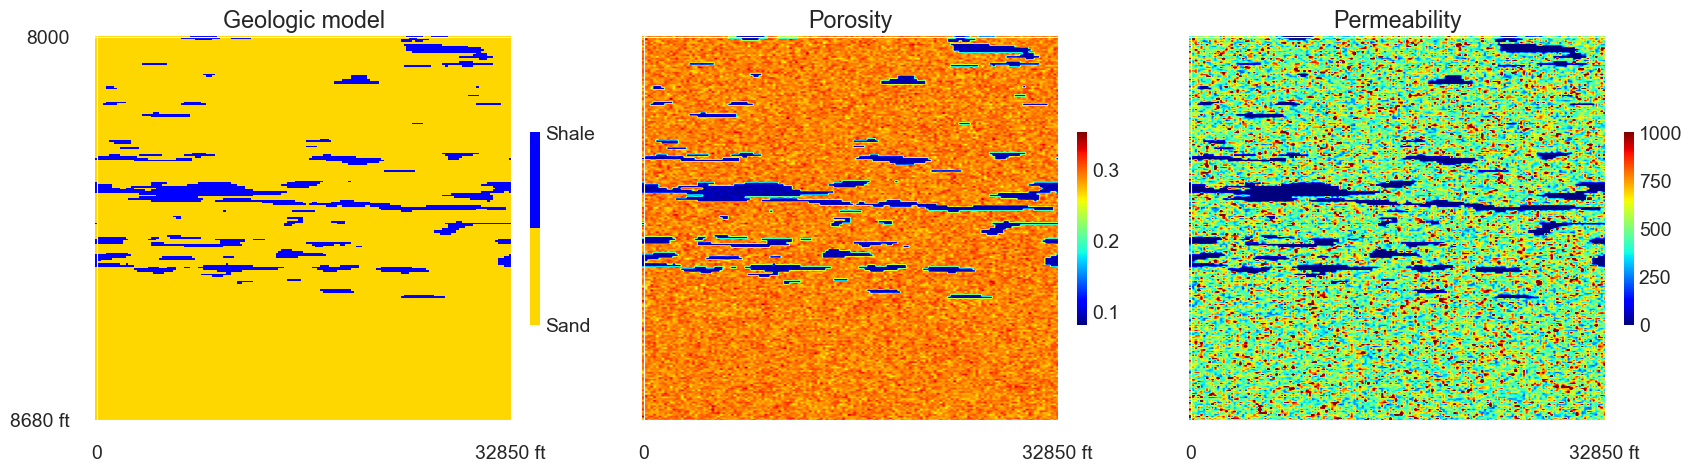

In [3]:
# Plot geological model and petrophysical properties
bdp.geo_properties(rel_perm,porosity,perm)

In [9]:
path = 'C:/Users/ubillusj/Desktop/CMG/Ubillus_simulations/hyskrg_midpoint/'
paths = ['brooks_corey_sim/Results_linear/S1/','van_genuchten_sim/Results_linear/S1/']

# dictionaries that will store the different variable results for each simulation
# Brooks-Corey linear
bc_gas = bdp.mul_list_to_array(path + paths[0],'Het2D_krg_0.1_bc_linear Gas Saturation.gslib',shape,size=8)
bc_trp = bdp.mul_list_to_array(path + paths[0],'Het2D_krg_0.1_bc_linear Sg _ Sgc _ Hysteresis Dynamic trapped gas saturation.gslib',shape,size=8)
bc_p = bdp.mul_list_to_array(path + paths[0],'Het2D_krg_0.1_bc_linear Pressure.gslib',shape,size=2)
bc_sp = bdp.special_table(path + paths[0],'special.xlsx')

# Van Genuchten linear
vg_gas = bdp.mul_list_to_array(path + paths[1],'Het2D_krg_0.1_vg_linear Gas Saturation.gslib',shape,size=8)
vg_trp = bdp.mul_list_to_array(path + paths[1],'Het2D_krg_0.1_vg_linear Sg _ Sgc _ Hysteresis Dynamic trapped gas saturation.gslib',shape,size=8)
vg_p = bdp.mul_list_to_array(path + paths[1],'Het2D_krg_0.1_vg_linear Pressure.gslib',shape,size=2)
vg_sp = bdp.special_table(path + paths[1],'special.xlsx')


In [10]:
# Permedia results 
path_permedia = '../Permedia_analysis/query1_1m_analysis_final.ptab'

# Read the data using pandas
permedia = pd.read_table(path_permedia,sep='\t',header=0)

# Reconstruct the meshgrid with dimensions nx,ny,nz
nx = 786 ; ny = 1 ; nz = 395

sat = np.zeros((nz,nx))

for i in range(len(permedia)):
    sat[permedia['z'][i],permedia['x'][i]] = permedia['pore_saturation_analysis_mean'][i]

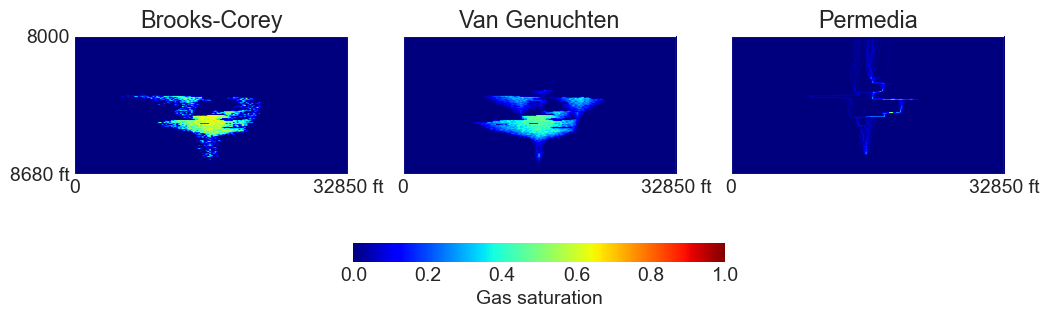

In [41]:
# Plot the final plume shape for each simulation
fig, ax = plt.subplots(1,3,figsize=(12,6))
im = ax[0].imshow(bc_gas[:,:,-1],cmap='jet',extent=[0,786,0,395],vmin=0,vmax=1)
ax[0].set_title('Brooks-Corey')
ax[1].imshow(vg_gas[:,:,-1],cmap='jet',extent=[0,786,0,395],vmin=0,vmax=1)
ax[1].set_title('Van Genuchten')
ax[2].imshow(sat,cmap='jet',extent=[0,786,0,395],vmin=0,vmax=1)
ax[2].set_title('Permedia')

for axi in ax.flat:
    axi.set_xticks([0,786])
    axi.set_yticks([0,395])
    axi.set_xticklabels(['0','32850 ft'])
    axi.set_yticklabels(['8680 ft','8000'])
    axi.label_outer()

fig.colorbar(im,ax=ax.ravel().tolist(),orientation='horizontal',shrink=0.4,label='Gas saturation')
plt.show()

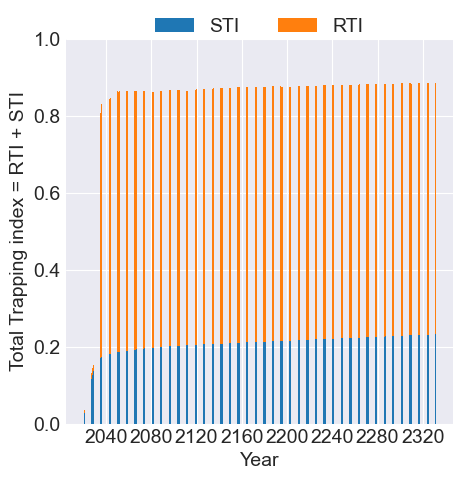

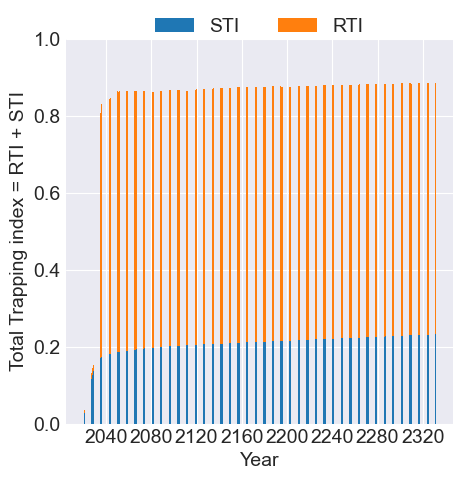

In [20]:
# Residual trapping index

idx_bc = bdp.indexes(bc_sp['Dissolved'],bc_sp['Trapped'],bc_sp['Super-critical'],4.83e9)
bdp.plot_indexes(bc_sp['Date'],idx_bc[0],idx_bc[1])


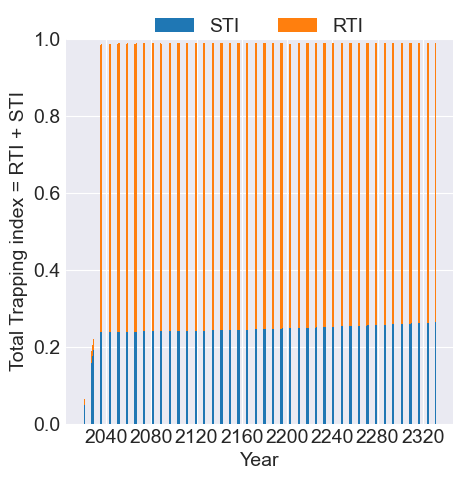

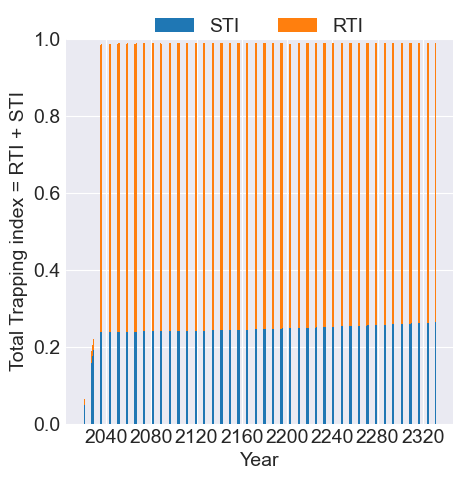

In [21]:
# van Genuchten residual trapping index
idx_vg = bdp.indexes(vg_sp['Dissolved'],vg_sp['Trapped'],vg_sp['Super-critical'],4.83e9)
bdp.plot_indexes(vg_sp['Date'],idx_vg[0],idx_vg[1])

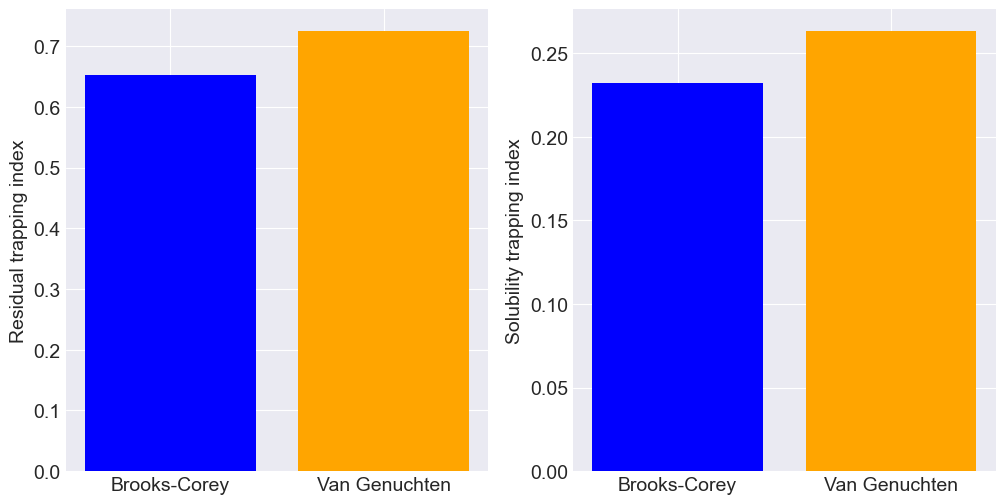

In [23]:
# Compare residual and solubility trapping indexes for both simulations
rti = [idx_bc[0][-1],idx_vg[0][-1]]
sti = [idx_bc[1][-1],idx_vg[1][-1]]
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].bar(['Brooks-Corey','Van Genuchten'],rti,color=['blue','orange'])
ax[0].set_ylabel('Residual trapping index')
ax[1].bar(['Brooks-Corey','Van Genuchten'],sti,color=['blue','orange'])
ax[1].set_ylabel('Solubility trapping index')
plt.show()

In [28]:
# Estimate the moments of the plume for each simulation
def moments(sat,poro,vol,x,z):
    por_vol = poro*vol
    c10 = por_vol*x
    c01 = por_vol*z
    c20 = por_vol*x**2
    c02 = por_vol*z**2

    m00 = np.sum(sat*por_vol,axis=(0,1))
    m10, m01 = np.sum(sat*c10,axis=(0,1)), np.sum(sat*c01,axis=(0,1))
    m20, m02 = np.sum(sat*c20,axis=(0,1)), np.sum(sat*c02,axis=(0,1))

    #center of mass
    cx = m10/m00
    cz = m01/m00

    #spreading  
    sx = m20/m00 - cx**2
    sz = m02/m00 - cz**2
    
    return m00, cx, cz, sx, sz

# Brooks-Corey
bc_moments = moments(bc_gas[:,:,-1],porosity,volume,x,z)
# Van Genuchten
vg_moments = moments(vg_gas[:,:,-1],porosity,volume,x,z)
# Permedia
xp, zp  = np.meshgrid(np.arange(0,786), np.arange(0,395))
xp = 13*3.28*xp ; zp = 0.5*3.28*zp
vol_array = np.zeros((nz,nx))
vol_array[0:270,:] = 38544
vol_array[270:,:] = 87600
por_vol = 0.25*vol_array*np.ones((nz,nx))

c10 = por_vol*xp ; c01 = por_vol*zp
c20 = por_vol*xp**2 ; c02 = por_vol*zp**2

m00 = np.sum(sat*por_vol)
m10 = np.sum(c10*sat)
m01 = np.sum(c01*sat)
m20 = np.sum(c20*sat)
m02 = np.sum(c02*sat)

cx = m10/m00 ; cz = m01/m00
sx = m20/m00 - cx**2 ; sy = m02/m00 - cz**2

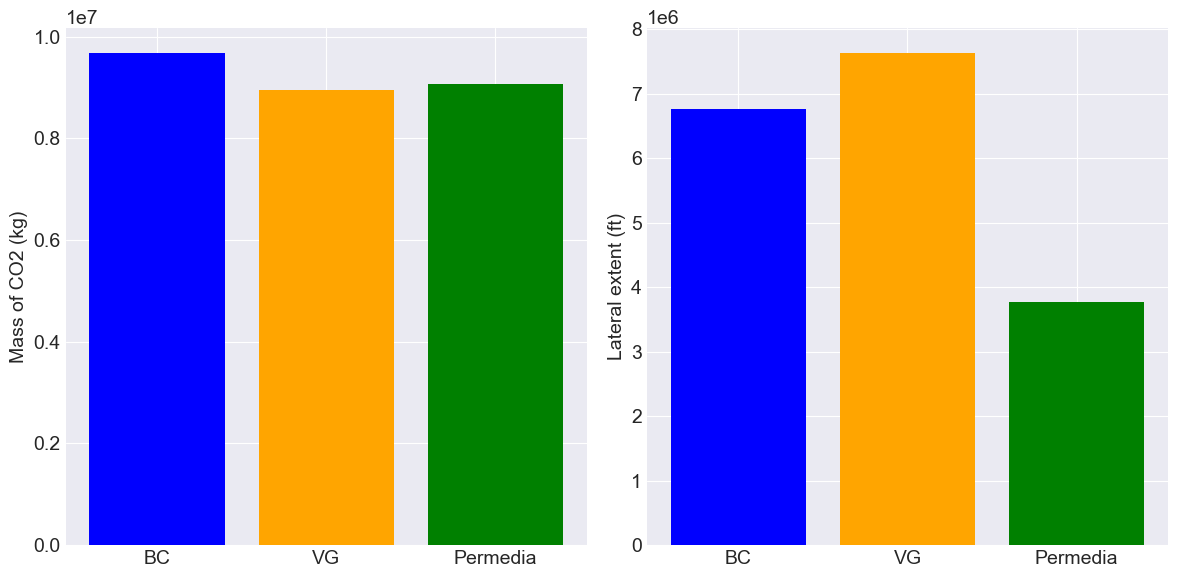

In [42]:
# Plot m00, centroid and lateral extent of the plume for three cases
m00_array = np.array([bc_moments[0],vg_moments[0],m00])
#cx_array = np.array([bc_moments[1],vg_moments[1],cx])
sz_array = np.array([bc_moments[3],vg_moments[3],sx])
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].bar(['BC','VG','Permedia'],m00_array,color=['blue','orange','green'])
ax[0].set_ylabel('Mass of CO2 (kg)')
#ax[1].bar(['BC','VG','Permedia'],cx_array,color=['blue','orange','green'])
#ax[1].set_ylabel('Centroid x (ft)')
ax[1].bar(['BC','VG','Permedia'],sz_array,color=['blue','orange','green'])
ax[1].set_ylabel('Lateral extent (ft)')
plt.tight_layout()
plt.show()